# Demonstration of how to create a spot ladder

The sheet books and values 2 vanilla options, one call, one put and demonstrates how you can create a spot ladders from the valuation data showing PV and Delta across different underlying spot rates

**Table of Contents:**
- [1. Create Portfolio](#1.-Create-Portfolio)
- [2. Create Instrument](#2.-Create-Instrument)
- [3. Upsert Transactions](#3.-Upsert-Transactions)
- [4. Upsert FX Market Data](#4.-Upsert-FX-Market-Data)
- [5. Create Configuration Recipe](#5.-Create-Configuration-Recipe)
- [6. Spot Ladder Calculation](#6.-Spot-Ladder-Calculation)

In [309]:
# Import generic non-LUSID packages
import os
import pandas as pd
from datetime import datetime, timedelta
import re
import matplotlib.pyplot as plt
%matplotlib inline
import json
import pytz
import uuid
from IPython.core.display import HTML

# Import key modules from the LUSID package
import lusid
import lusid.models as lm
import lusid.api as la
from lusid.utilities import ApiClientFactory
from lusidtools.pandas_utils.lusid_pandas import lusid_response_to_data_frame

# Import key functions from Lusid-Python-Tools and other packages
from lusidjam import RefreshingToken

# Set DataFrame display formats
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.options.display.float_format = "{:,.4f}".format
display(HTML("<style>.container { width:90% !important; }</style>"))

# Set the secrets path
secrets_path = os.getenv("FBN_SECRETS_PATH")

# For running the notebook locally
if secrets_path is None:
    secrets_path = os.path.join(os.path.dirname(os.getcwd()), "secrets.json")

# Authenticate our user and create our API client
api_factory = ApiClientFactory(
    token=RefreshingToken(),
    api_secrets_filename = secrets_path)

print ('LUSID Environment Initialised')
print ('LUSID API Version :', api_factory.build(lusid.api.ApplicationMetadataApi).get_lusid_versions().build_version)

LUSID Environment Initialised
LUSID API Version : 0.6.9676.0


In [310]:
# Set required APIs
portfolio_api = api_factory.build(lusid.api.PortfoliosApi)
transaction_portfolios_api = api_factory.build(lusid.api.TransactionPortfoliosApi)
instruments_api = api_factory.build(lusid.api.InstrumentsApi)
quotes_api = api_factory.build(lusid.api.QuotesApi)
configuration_recipe_api = api_factory.build(lusid.api.ConfigurationRecipeApi)
complex_market_data_api = api_factory.build(lusid.api.ComplexMarketDataApi)
aggregation_api = api_factory.build(lusid.api.AggregationApi)

In [311]:
# Define scopes
scope = "ibor-opt"
market_data_scope = "ibor-opt"
market_supplier = "Lusid"

# 1. Create Portfolio

We begin by creating a portfolio that will contain the FX option instrument that we will be looking to price.

In [312]:
portfolio_code = "fxOption"

try:
    transaction_portfolios_api.create_portfolio(
        scope=scope,
        create_transaction_portfolio_request=lm.CreateTransactionPortfolioRequest(
            display_name=portfolio_code,
            code=portfolio_code,
            base_currency="EUR",
            created="2010-01-01",
            sub_holding_keys=[],
            instrument_scopes=[scope]
        ),
    )

except lusid.ApiException as e:
    print(e.body)

# 2. Create Instrument

Using the below method we can reference the SDK models to populate the required parameters for creating an FX Option. We then populate the instrument variables, and make a call to persist the instrument in LUSID.

In [313]:
# Define function that creates an FX option
def create_fx_option(strike, dom_ccy, fgn_ccy, start_date, maturity_date, settlement_date, isCall, isCashDelivery = False, isPayoffDigital = False):

    return lm.FxOption(
        strike = strike,
        dom_ccy = dom_ccy,
        fgn_ccy = fgn_ccy,
        start_date = start_date,
        option_maturity_date = maturity_date,
        option_settlement_date = settlement_date,
        is_call_not_put = isCall,
        is_delivery_not_cash = not isCashDelivery,
        is_payoff_digital = isPayoffDigital,
        instrument_type = "FxOption",
        dom_amount = 1,
        premium = lm.Premium(
            currency = 'EUR',
            amount = 0.02,
            date =  start_date + timedelta(days=settle_days)    
        )
    )

# Define a function to upsert instrument
def upsert_instrument_to_lusid(scope, instrument_definition, name, identifier, identifier_type):
        return instruments_api.upsert_instruments(
            request_body={
                identifier: lm.InstrumentDefinition(
                    name=name,
                    identifiers={
                        identifier_type: lm.InstrumentIdValue(value=identifier)
                    },
                    definition=instrument_definition,
                )
            },
            scope = scope
        )

# 3. Upsert Transactions

Having created the portfolio, we add a _StockIn_ transaction against the option to create a position without incurring any costs. Notice that this transaction type will simply increase our position by the given units, as opposed to a typical _Buy_/_Sell_, that would also impact cash.

In [314]:
# Set trade variables
trade_date = datetime(2021, 1, 20, tzinfo=pytz.utc)
start_date = trade_date
settle_days = 2
units = 1000000
dom_ccy = "EUR"
fgn_ccy = "USD"
identifier_type = "ClientInternal"

# lets book 2 vanilla options one, call and one put.

for i in range(1,3):

    strike = 1.2171
    maturity_date = start_date + timedelta(days = 30)
    settlement_date = maturity_date + timedelta(days = settle_days)

    option_name = "EUR/USD FX Option " + maturity_date.strftime("%m/%d/%Y")  + " " + str(strike)
    option_identifier = "OPT-EURUSD" + "-" +  maturity_date.strftime("%m/%d/%Y") + "-" + str(i)
    
    # Create the Instrument
    option_definition = create_fx_option(
        strike = strike,
        dom_ccy = dom_ccy,
        fgn_ccy = fgn_ccy,
        start_date = start_date,
        maturity_date = maturity_date,
        settlement_date = settlement_date,
        isCall = (i==2),
        isCashDelivery = False,
        isPayoffDigital = False
    )

    # Upsert the instrument
    upsert_response = upsert_instrument_to_lusid(scope, option_definition, option_name, option_identifier, identifier_type)
    luid = upsert_response.values[option_identifier].lusid_instrument_id
    print(luid)

    # Book a StockIn transaction against the option
    opt_txn = lm.TransactionRequest(
        transaction_id="TXN00" + str(i),
        type="StockIn",
        instrument_identifiers={"Instrument/default/ClientInternal": option_identifier},
        transaction_date=trade_date,
        settlement_date=trade_date + timedelta(days=settle_days),
        units=units,
        transaction_price=lm.TransactionPrice(price=1,type="Price"),
        total_consideration=lm.CurrencyAndAmount(amount=1,currency="EUR"),
        exchange_rate=1,
        transaction_currency="EUR"
    )

    response = transaction_portfolios_api.upsert_transactions(scope=scope,
                                                        code=portfolio_code,
                                                        transaction_request=[opt_txn])

    print(f"Transaction successfully updated at time: {response.version.as_at_date}")

LUID_00003E2X
Transaction successfully updated at time: 2022-07-22 14:00:34.692554+00:00
LUID_00003E2Y
Transaction successfully updated at time: 2022-07-22 14:00:35.196567+00:00


# 4. Upsert FX Market Data

Next we will be loading the required marked data into the quotes store. In this particular example, we will require the following data:
1. EUR/USD Spot Rates
2. EUR and USD discount curves
3. EURUSD volatility surface

# 4.1 FX Spot Rates

We begin by adding the FX spot rates, which are the first piece of market data required to value an FX Option on a given day.

In [315]:
# Read fx spot rates and make datetimes timezone aware
quotes_df = pd.read_csv("data/eurusd_spot.csv")
quotes_df["Date"] = pd.to_datetime(quotes_df["Date"], dayfirst=True)
quotes_df["Date"] = quotes_df["Date"].apply(lambda x: x.replace(tzinfo=pytz.utc))
quotes_df.head()

,Date,Rate,Pair
0,2021-01-01 00:00:00+00:00,1.2215,EUR/USD
1,2021-01-04 00:00:00+00:00,1.2248,EUR/USD
2,2021-01-05 00:00:00+00:00,1.2298,EUR/USD
3,2021-01-06 00:00:00+00:00,1.2327,EUR/USD
4,2021-01-07 00:00:00+00:00,1.2272,EUR/USD


In [316]:
# Create quotes request
instrument_quotes = {
            index: lm.UpsertQuoteRequest(
            quote_id=lm.QuoteId(
                quote_series_id=lm.QuoteSeriesId(
                    provider=market_supplier,
                    instrument_id=row["Pair"],
                    instrument_id_type="CurrencyPair",
                    quote_type="Rate",
                    field="mid",
                ),
                effective_at=row["Date"],
            ),
            metric_value=lm.MetricValue(value=row["Rate"], unit=row["Pair"]),
        )
    for index, row in quotes_df.iterrows()
}

# Upsert quotes into LUSID
response = quotes_api.upsert_quotes(
    scope=market_data_scope, request_body=instrument_quotes
)

if response.failed != {}:
    print(f"Some failures occurred during quotes upsertion, {len(response.failed)} did not get loaded into LUSID.")

# 4.2 EUR & USD Discount curves

Next we will read in the EUR and USD Discount factors and create separate OIS curves

In [317]:
# Read FX market data - showing first 10 terms
df_market_data = pd.read_csv("data/EURUSD-MarketData.csv")
df_market_data["Days"]= df_market_data["Days"].astype(int)
df_market_data = df_market_data.reset_index()
df_market_data.head(10)

,index,Tenor,Days,EUR-Rates,USD-Rates,EURdf,USDdf,EURUSDFwd,ATMFVol
0,0,1M,30,0.2200,1.2200,0.9998,0.9990,1.2059,0.1039
1,1,2M,60,0.3700,1.3700,0.9994,0.9978,1.2069,0.1013
2,2,3M,90,0.5300,1.5300,0.9987,0.9962,1.2079,0.0957
3,3,6M,180,0.9500,1.9500,0.9953,0.9904,1.2109,0.0969
4,4,1Y,365,1.3000,2.3000,0.9871,0.9773,1.2170,0.1035
5,5,18M,547,1.5000,2.5000,0.9778,0.9632,1.2231,0.0951
6,6,2Y,730,1.5000,2.5000,0.9705,0.9513,1.2292,0.1021
7,7,3Y,1095,1.4300,2.4300,0.9580,0.9297,1.2416,0.1014
8,8,4Y,1460,1.3700,2.3700,0.9467,0.9096,1.2541,0.0966
9,9,5Y,1825,1.3100,2.3100,0.9366,0.8909,1.2667,0.1017


In [318]:
# Set up the OIS curves loader function
def upsert_discount_factors(scope, effective_at, market_asset, dates, dfs):

    complex_market_data = lm.DiscountFactorCurveData(
        base_date=effective_at,
        dates=dates,
        discount_factors = dfs,
        market_data_type="DiscountFactorCurveData"
    )

    # create a unique identifier for our OIS yield curves
    complex_id = lm.ComplexMarketDataId(
        provider=market_supplier,
        price_source = market_supplier,
        effective_at=effective_at,
        market_asset=market_asset,
    )
    
    upsert_request = lm.UpsertComplexMarketDataRequest(
        market_data_id=complex_id, market_data=complex_market_data
    )


    response = complex_market_data_api.upsert_complex_market_data(
        scope=scope, request_body={market_asset: upsert_request}
    )
    
    if response.failed:
        raise StopExecution("Failed to upload yield curve {response.failed}")

    print(f"{market_asset} yield curve uploaded into scope={scope}")
    
    return complex_id

In [319]:
# Set up the OIS curves
base_date = trade_date
dates = []
dfs = []

for index, row in df_market_data.iterrows():
    dates.append(base_date + timedelta(days=row["Days"]))
    dfs.append(row["EURdf"])

curve_id_EUR = upsert_discount_factors(market_data_scope, base_date, "EUR/EUROIS", dates, dfs)


dates = []
dfs = []

for index, row in df_market_data.iterrows():
    dates.append(base_date + timedelta(days=row["Days"]))
    dfs.append(row["USDdf"])
    
curve_id_USD = upsert_discount_factors(market_data_scope, base_date, "USD/USDOIS", dates, dfs)

EUR/EUROIS yield curve uploaded into scope=ibor-opt
USD/USDOIS yield curve uploaded into scope=ibor-opt


We can also use the _ComplexMarketDataApi_ to retrieve the data as it's been stored in LUSID. See below for the returned object, and a plot showing both OIS discount curves.

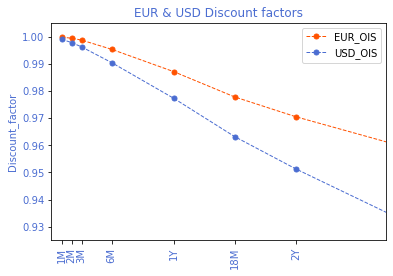

In [320]:
# Retrieve curve
EUR_OIS_curve = complex_market_data_api.get_complex_market_data(
    scope=market_data_scope,
    request_body= {"1": curve_id_EUR}
)

USD_OIS_curve = complex_market_data_api.get_complex_market_data(
    scope=market_data_scope,
    request_body= {"1": curve_id_USD}
)

# Get axis data and create plot
plt.plot(df_market_data["Days"],EUR_OIS_curve.values["1"].discount_factors, color='#ff5200' , marker='o', markersize=5, linestyle='--', linewidth=1, label="EUR_OIS")
plt.plot(df_market_data["Days"],USD_OIS_curve.values["1"].discount_factors, color='#4b6dd1' , marker='o', markersize=5, linestyle='--', linewidth=1, label="USD_OIS")

plt.xticks(df_market_data["Days"], df_market_data["Tenor"], rotation='vertical', color = '#4b6dd1')
plt.yticks(color = '#4b6dd1')
plt.title('EUR & USD Discount factors', color = '#4b6dd1')
plt.ylabel('Discount_factor', color = '#4b6dd1')
plt.xlim([0, 1000]), plt.ylim([.925, 1.005])
plt.legend(loc="upper right")
plt.show()

# 4.3 FX Volatility Surface
Next we will read in our FX Vol surface data, and need to create a set of vanilla option instruments at the ATMF forward price for each tenor in the market data

In [321]:
curve_instruments = []
curve_instruments_id = []

for index, row in df_market_data.iterrows():

    option_expiry = base_date + timedelta(days=row["Days"])
    
    # Create the Instrument - constant strike at the 6M fwd point
    option_definition = create_fx_option(
        strike = 1.2109,
        dom_ccy = dom_ccy,
        fgn_ccy = fgn_ccy,
        start_date = base_date,
        maturity_date = option_expiry,
        settlement_date =option_expiry + timedelta(days=2),
        isCall = True,
        isPayoffDigital = False,
        isCashDelivery = False,
    )
    
    option_name = "EUR/USD " + row["Tenor"] + " FX Option " + option_expiry.strftime("%m/%d/%Y")
    option_identifier = str(uuid.uuid4())
    
    curve_instruments.append(option_definition)
    
    # Upsert the instrument
    upsert_response = upsert_instrument_to_lusid(scope, option_definition, option_name, option_identifier, identifier_type)
    curve_instruments_id.append(upsert_response.values[option_identifier].lusid_instrument_id)
    
print(f"{len(curve_instruments)} instruments uploaded to create the vol curve")

19 instruments uploaded to create the vol curve


In [322]:
# load the surface into Lusid

def upsert_fx_vol(scope, effective_at, market_asset, instruments, vols):

    market_data_id = lm.ComplexMarketDataId(
        provider=market_supplier,
        price_source="Lusid",
        effective_at=effective_at,
        market_asset=market_asset,
    )
    
    quotes = []
    
    for vol in vols:
        quotes.append(lm.MarketQuote(quote_type="LogNormalVol", value=vol))
                    

    fx_vol_surface_data = lm.FxVolSurfaceData(
        base_date=effective_at,
        instruments=instruments,
        quotes=quotes,
        market_data_type="FxVolSurfaceData"
    )
    
    response = complex_market_data_api.upsert_complex_market_data(
        scope=scope,
        request_body={
            market_asset: lm.UpsertComplexMarketDataRequest(
                market_data_id=market_data_id, market_data=fx_vol_surface_data
            )
        },
    )
    
    if len(response.failed) == 0:
        print(f"Quote successfully loaded into LUSID. {len(response.values)} quotes loaded.")

    else:
        print(f"Some failures occurred during quotes upsertion, {len(response.failed)} did not get loaded into LUSID.")
        
    return market_data_id

In [323]:
EURUSD_vol_curve_id = upsert_fx_vol(market_data_scope, base_date, "EUR/USD/LN", curve_instruments, df_market_data["ATMFVol"])
display(EURUSD_vol_curve_id)

Quote successfully loaded into LUSID. 1 quotes loaded.


{'effective_at': datetime.datetime(2021, 1, 20, 0, 0, tzinfo=<UTC>),
 'lineage': None,
 'market_asset': 'EUR/USD/LN',
 'price_source': 'Lusid',
 'provider': 'Lusid'}

# 5. Create Configuration Recipe

In order to run a valuation, LUSID will require a recipe that drives how a valuation will be conducted. The below recipe defines what model and market data to use in this context.


In [324]:
# Set recipe code
recipe_code = "OptValuation"

# Populate recipe parameters
configuration_recipe = lm.ConfigurationRecipe(
    scope=market_data_scope,
    code=recipe_code,
    market=lm.MarketContext(
        market_rules=[
            lm.MarketDataKeyRule(
                    key="FX.CurrencyPair.*",
                    supplier=market_supplier,
                    data_scope=market_data_scope,
                    quote_type="Rate",
                    field="mid",
                    quote_interval="90D"
                ),
            lm.MarketDataKeyRule(
                key="FXVol.*.*.*",
                supplier=market_supplier,
                data_scope=market_data_scope,
                price_source=market_supplier,
                quote_type="Price",
                field="mid",
                quote_interval="90D",
            ),
            lm.MarketDataKeyRule(
                key="Rates.*.*",
                supplier=market_supplier,
                data_scope=market_data_scope,
                price_source=market_supplier,
                quote_type="Price",
                field="mid",
                quote_interval="90D",
            ),
        ],
    ),
    pricing=lm.PricingContext(
        model_rules=[
            lm.VendorModelRule(
                supplier="Lusid",
                model_name="BlackScholes",
                instrument_type="FXOption",
                parameters="{}",
            )
        ],
    ),
)

response = configuration_recipe_api.upsert_configuration_recipe(
    upsert_recipe_request=lm.UpsertRecipeRequest(
        configuration_recipe=configuration_recipe
    )
)


print(f"Configuration recipe loaded into LUSID at time {response.value}.")

Configuration recipe loaded into LUSID at time 2022-07-22 14:00:42.238571+00:00.


In [325]:
def run_valuation(date, portfolio_code):

    metrics = [
        lm.AggregateSpec("Instrument/default/Name", "Value"),
        lm.AggregateSpec("Instrument/default/ClientInternal", "Value"),
        lm.AggregateSpec("Holding/default/Units", "Value"),
        lm.AggregateSpec("Valuation/PV/Amount", "Value"),
        lm.AggregateSpec("Valuation/PvInPortfolioCcy", "Value"),
        lm.AggregateSpec("Valuation/Delta", "Value"),
        lm.AggregateSpec("Valuation/Risk/SpotDelta", "Value"),
        lm.AggregateSpec("Valuation/CleanPriceKey", "Value"),
    ]

    group_by =[]

    valuation_request = lm.ValuationRequest(
        recipe_id=lm.ResourceId(scope=market_data_scope, code=recipe_code),
        metrics=metrics,
        group_by=group_by,
        portfolio_entity_ids=[
            lm.PortfolioEntityId(scope=scope, code=portfolio_code)
        ],
        valuation_schedule=lm.ValuationSchedule(effective_at=date),
    )

    val_data = aggregation_api.get_valuation(valuation_request=valuation_request).data

    vals_df = pd.DataFrame(val_data)

    vals_df.rename(
        columns={
            "Instrument/default/Name": "InstrumentName",
            "Instrument/default/ClientInternal": "ClientInternal",
            "Valuation/PvInPortfolioCcy": "Market Value",
            "Valuation/Diagnostics/FxForwardRate": "Forward Rate (Interpolated)",
            "Quotes/FxRate/DomFgn": "FX Spot Rate",
            "Valuation/PnL/Tm1/Pfolio": "PnL (1-day)"
        },
        inplace=True,
    )

    return vals_df

In [326]:
valuation = run_valuation(base_date, portfolio_code)
display(valuation)

,Valuation/PV/Amount,InstrumentName,ClientInternal,Holding/default/Units,Market Value,Valuation/Delta,Valuation/Risk/SpotDelta,Valuation/CleanPriceKey
0,"-5,671.2174",EUR/USD FX Option 02/19/2021 1.2171,OPT-EURUSD-02/19/2021-1,"1,000,000.0000","-5,671.2174",-0.5543,-0.0001,-0.0057
1,"-10,235.0866",EUR/USD FX Option 02/19/2021 1.2171,OPT-EURUSD-02/19/2021-2,"1,000,000.0000","-10,235.0866",0.4447,0.0001,-0.0102


# 6. Spot Ladder Calculation

In [327]:
# get the base spot rate

calculation_date = datetime(2021, 1, 23, tzinfo=pytz.utc)
quotes = {}

quotes = lm.QuoteSeriesId(
    provider=market_supplier,
    instrument_id="EUR/USD",
    instrument_id_type="CurrencyPair",
    quote_type="Rate",
    field="mid")

quotes_response = quotes_api.get_quotes(
    scope = market_data_scope,
    effective_at = calculation_date,
    request_body = {"1" : quotes}
)
                                         
spot_rate = quotes_response.values["1"].metric_value.value
display(spot_rate)

1.2471

In [328]:
def upsert_single_quote (spot, calculation_date):
    # Create quotes request
    instrument_quotes = {
            "1" : lm.UpsertQuoteRequest(
            quote_id=lm.QuoteId(
                quote_series_id=lm.QuoteSeriesId(
                    provider=market_supplier,
                    instrument_id="EUR/USD",
                    instrument_id_type="CurrencyPair",
                    quote_type="Rate",
                    field="mid",
                ),
                effective_at=calculation_date,
            ),
            metric_value=lm.MetricValue(value=spot, unit="EUR/USD"),
        )
    }

    # Upsert quotes into LUSID
    response = quotes_api.upsert_quotes(
        scope=market_data_scope, request_body=instrument_quotes
    )

    if response.failed != {}:
        print(f"Some failures occurred during quotes upsertion, {len(response.failed)} did not get loaded into LUSID.")

In [329]:
bump = 0.01

spot_ladder_pvs = pd.DataFrame()

for i in range (-10 , 5):
    rung_spot = spot_rate + (i * bump)
    upsert_single_quote (rung_spot, calculation_date)
    valuation = run_valuation(calculation_date, portfolio_code)
    valuation["spot_rate"] = rung_spot
    spot_ladder_pvs = pd.concat([spot_ladder_pvs, valuation], axis=0)
    

#tidy up and reset the spot rate
upsert_single_quote (spot_rate, calculation_date)
    

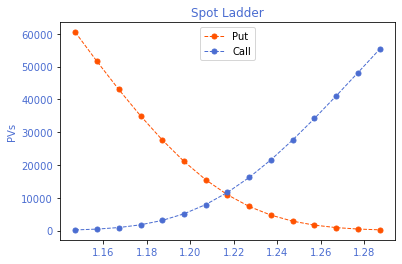

In [330]:
# Get axis data and create plot
opt1 = spot_ladder_pvs[spot_ladder_pvs["ClientInternal"] == "OPT-EURUSD-02/19/2021-1"]
opt2 = spot_ladder_pvs[spot_ladder_pvs["ClientInternal"] == "OPT-EURUSD-02/19/2021-2"]

plt.plot(opt1["spot_rate"],opt1["Valuation/PV/Amount"], color='#ff5200' , marker='o', markersize=5, linestyle='--', linewidth=1, label="Put")
plt.plot(opt2["spot_rate"],opt2["Valuation/PV/Amount"], color='#4b6dd1' , marker='o', markersize=5, linestyle='--', linewidth=1, label="Call")

plt.title('Spot Ladder', color = '#4b6dd1')
plt.ylabel('PVs', color = '#4b6dd1')
plt.xticks(color = '#4b6dd1')
plt.yticks(color = '#4b6dd1')
plt.legend(loc="upper center")
plt.show()

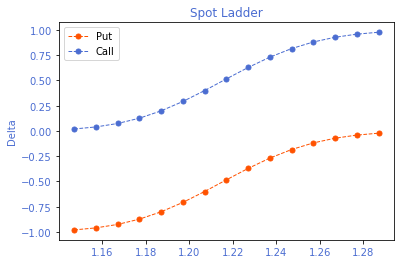

In [331]:
plt.plot(opt1["spot_rate"],opt1["Valuation/Delta"], color='#ff5200' , marker='o', markersize=5, linestyle='--', linewidth=1, label="Put")
plt.plot(opt2["spot_rate"],opt2["Valuation/Delta"], color='#4b6dd1' , marker='o', markersize=5, linestyle='--', linewidth=1, label="Call")

plt.title('Spot Ladder', color = '#4b6dd1')
plt.ylabel('Delta', color = '#4b6dd1')
plt.xticks(color = '#4b6dd1')
plt.yticks(color = '#4b6dd1')
plt.legend(loc="upper left")
plt.show()